In [1]:
import torch
from IPython import display
from d2l import torch as d2l
from Image_translation_processing import load_data_fashion_mnist
# 每次读取256大小的
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [2]:
# 输入 28*28
num_inputs = 784
# 输出
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [3]:
# softmax函数
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [4]:
# 正向求预测结果的网络 返回一个二维张量
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [5]:
# 损失函数 y_hat为对应预测值 y为实际分类 
# one_hot向量乘以对应概率 只用取对应位置上的概率取log就行
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])


In [6]:
# 返回预测正确的种类数量
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    # 先获取y的type然后将预测值y_hat转换为y的类型
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [7]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def evaluate_accuracy(net, data_iter):  
    """计算在指定数据集上模型的精度"""
    # 是否是传统的torch.nn.Module类型
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            # 累加正确的值 和 预测总数
            metric.add(accuracy(net(X), y), y.numel())
    return metric.data[0] / metric.data[1]

In [8]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        # updater是我们定义的sgd等函数
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            # 更新参数
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric.data[0] / metric.data[2], metric.data[1] / metric.data[2]

In [9]:
class Animator:  #@save
    """在动画中绘制数据"""
    # x、y轴标签，legend图例、xlim设置轴的显示范围、scale刻度尺度
    # fmts绘图格式，线的格式 nrows子图行数、列数 figsize图形尺寸
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        # 图例为空则初始化为一个空列表
        if legend is None:
            legend = []
        # 设置图片显示为svg格式
        d2l.use_svg_display()
        # subplots指定创建的子图的行数 子图的列数 figsize指定图形尺寸
        # fig当中保存图形对象，控制整个图行，保存、修改标题、设置背景色
        # axes保存一个/多个子图，子图对象可以绘制具体的数据和设置子图属性
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        # axes同意转换为列表
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数 置子图的轴标签、轴范围、刻度和图例等属性
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点 实时更新图标
        # y是否可迭代 不可转换为列表
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
        # 确保x与y的个数一致
            x = [x] * n
        # 为空初始化
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        # enumerate为同时迭代数据和索引
        for i, (a, b) in enumerate(zip(x, y)):
            # （a,b) 都不空加入图标
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        # 清除子图 以便更新数据后重新绘制
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            #绘制子图
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        # 用于清除输出，以便在动画中实现数据的实时更新和显示
        display.clear_output(wait=True)

In [10]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    # 多个模型训练周期
    for epoch in range(num_epochs):
        # 训练迭代
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        # 准确率
        test_acc = evaluate_accuracy(net, test_iter)
        # 当前周期的训练集损失、训练集准确率和测试集准确率添加到 animator 对象中
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    # 断言 如果发生错误将会中断程序的执行
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [11]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

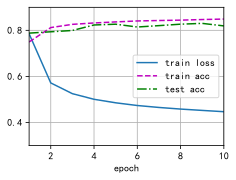

In [12]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)